# Synthetic Mortgage Loan Prepayment Data

Generate a panel of loan-month observations with a logit-based prepayment model driven by **age seasoning** and **rate incentive**.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def _sigmoid(x):
    """Numerically stable sigmoid."""
    return np.where(x >= 0,
                    1.0 / (1.0 + np.exp(-x)),
                    np.exp(x) / (1.0 + np.exp(x)))


def age_effect(age, peak_age=24, tail_sigma=60):
    """Seasoning ramp: 0 at birth, peaks at peak_age, then slowly decays.

    Rising phase: (a/peak) * exp(1 - a/peak)
    Decay phase:  Gaussian tail exp(-0.5*((a-peak)/sigma)^2) for a gentler decline.
    Both sides have zero derivative at peak, so the join is C1-smooth.
    """
    a = np.asarray(age, dtype=float)
    ramp = (a / peak_age) * np.exp(1.0 - a / peak_age)
    tail = np.exp(-0.5 * ((a - peak_age) / tail_sigma) ** 2)
    return np.where(a <= peak_age, ramp, tail)


def incentive_effect(incentive, midpoint=0.02, steepness=300.0):
    """S-curve (sigmoid) for refinancing incentive."""
    return _sigmoid(steepness * (np.asarray(incentive) - midpoint))


def generate_synthetic_loan_data(
    n_months: int = 60,
    loans_per_month: int = 100,
    base_rates: np.ndarray | None = None,
    base_rate_start: float = 0.05,
    spread_mean: float = 0.020,
    spread_std: float = 0.005,
    peak_age: int = 24,
    prepay_intercept: float = -9.0,
    age_coeff: float = 3.5,
    incentive_coeff: float = 3.5,
    incentive_midpoint: float = 0.01,
    incentive_steepness: float = 200.0,
    noise_std: float = 0.3,
    seed: int = 42,
) -> pd.DataFrame:
    """Generate a synthetic loan-month panel with prepayment.

    Prepayment model (monthly):
        logit(p) = intercept
                   + age_coeff   * age_effect(age)
                   + inc_coeff   * incentive_effect(loan_rate - base_rate)
                   + N(0, noise_std)

    Returns a DataFrame with one row per (loan, month) while the loan is alive.
    """
    rng = np.random.default_rng(seed)

    # --- base rate curve (deterministic default) ---
    # Smooth cosine cycle (~80-month period) with gentle upward drift.
    # Produces 2-3 big rate swings over 120 months, no micro-wiggles.
    if base_rates is None:
        t = np.arange(n_months, dtype=float)
        base_rates = (base_rate_start
                      + 0.012 * np.cos(2 * np.pi * t / 80)
                      + 0.0001 * t)
    base_rates = np.asarray(base_rates, dtype=float)
    assert len(base_rates) >= n_months

    frames: list[pd.DataFrame] = []

    for orig in range(n_months):
        # originate loans
        spreads = rng.normal(spread_mean, spread_std, loans_per_month).clip(min=0.003)
        loan_rates = base_rates[orig] + spreads
        active = np.ones(loans_per_month, dtype=bool)

        for cal in range(orig, n_months):
            n_act = active.sum()
            if n_act == 0:
                break

            age = cal - orig + 1
            cur_base = base_rates[cal]
            incentives = loan_rates[active] - cur_base

            a_eff = age_effect(age, peak_age)
            i_eff = incentive_effect(incentives, incentive_midpoint, incentive_steepness)

            logit_p = (prepay_intercept
                       + age_coeff * a_eff
                       + incentive_coeff * i_eff
                       + rng.normal(0, noise_std, n_act))
            probs = _sigmoid(logit_p)
            prepaid = rng.random(n_act) < probs

            act_idx = np.where(active)[0]
            frames.append(pd.DataFrame({
                'loan_id':            orig * loans_per_month + act_idx,
                'origination_month':  orig,
                'calendar_month':     cal,
                'loan_age':           age,
                'loan_rate':          loan_rates[active],
                'base_rate':          cur_base,
                'incentive':          incentives,
                'age_effect':         a_eff,
                'incentive_effect':   i_eff,
                'prepay_prob':        probs,
                'prepaid':            prepaid.astype(np.int8),
            }))

            active[act_idx[prepaid]] = False

    df = pd.concat(frames, ignore_index=True)
    df['loan_id'] = df['loan_id'].astype(int)
    return df

In [3]:
df = generate_synthetic_loan_data(n_months=120, loans_per_month=100)

print(f"rows        : {len(df):,}")
print(f"unique loans: {df['loan_id'].nunique():,}")
print(f"prepay rate : {df['prepaid'].mean():.4f}  (monthly avg)")
print()
df.head(10)

rows        : 310,336
unique loans: 12,000
prepay rate : 0.0288  (monthly avg)



,loan_id,origination_month,calendar_month,loan_age,loan_rate,base_rate,incentive,age_effect,incentive_effect,prepay_prob,prepaid
0,0,0,0,1,0.083524,0.062,0.021524,0.108639,0.909267,0.003869,0
1,1,0,0,1,0.076800,0.062,0.014800,0.108639,0.723125,0.003338,0
2,2,0,0,1,0.085752,0.062,0.023752,0.108639,0.939939,0.004334,0
3,3,0,0,1,0.086703,0.062,0.024703,0.108639,0.949816,0.006217,0
4,4,0,0,1,0.072245,0.062,0.010245,0.108639,0.512239,0.000819,0
5,5,0,0,1,0.075489,0.062,0.013489,0.108639,0.667704,0.001753,0
6,6,0,0,1,0.082639,0.062,0.020639,0.108639,0.893580,0.003088,0
7,7,0,0,1,0.080419,0.062,0.018419,0.108639,0.843401,0.003111,0
8,8,0,0,1,0.081916,0.062,0.019916,0.108639,0.879022,0.005011,0
9,9,0,0,1,0.077735,0.062,0.015735,0.108639,0.758954,0.001529,0


## Model Components

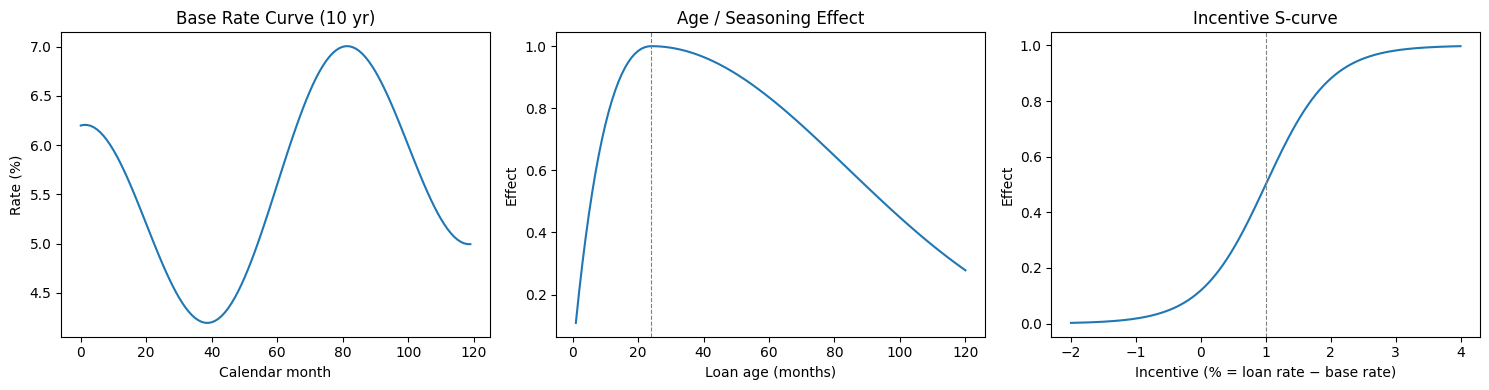

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1) base rate curve
t = np.arange(120, dtype=float)
br = 0.05 + 0.012 * np.cos(2 * np.pi * t / 80) + 0.0001 * t
axes[0].plot(t, br * 100)
axes[0].set(xlabel='Calendar month', ylabel='Rate (%)', title='Base Rate Curve (10 yr)')

# 2) age effect
ages = np.arange(1, 121)
axes[1].plot(ages, age_effect(ages, peak_age=24))
axes[1].axvline(24, ls='--', c='grey', lw=0.8)
axes[1].set(xlabel='Loan age (months)', ylabel='Effect', title='Age / Seasoning Effect')

# 3) incentive effect: incentive = loan_rate - base_rate
inc = np.linspace(-0.02, 0.04, 200)
axes[2].plot(inc * 100, incentive_effect(inc, midpoint=0.01, steepness=200))
axes[2].axvline(1.0, ls='--', c='grey', lw=0.8, label='midpoint')
axes[2].set(xlabel='Incentive (% = loan rate − base rate)', ylabel='Effect',
            title='Incentive S-curve')

fig.tight_layout()
plt.show()

## Data Analysis

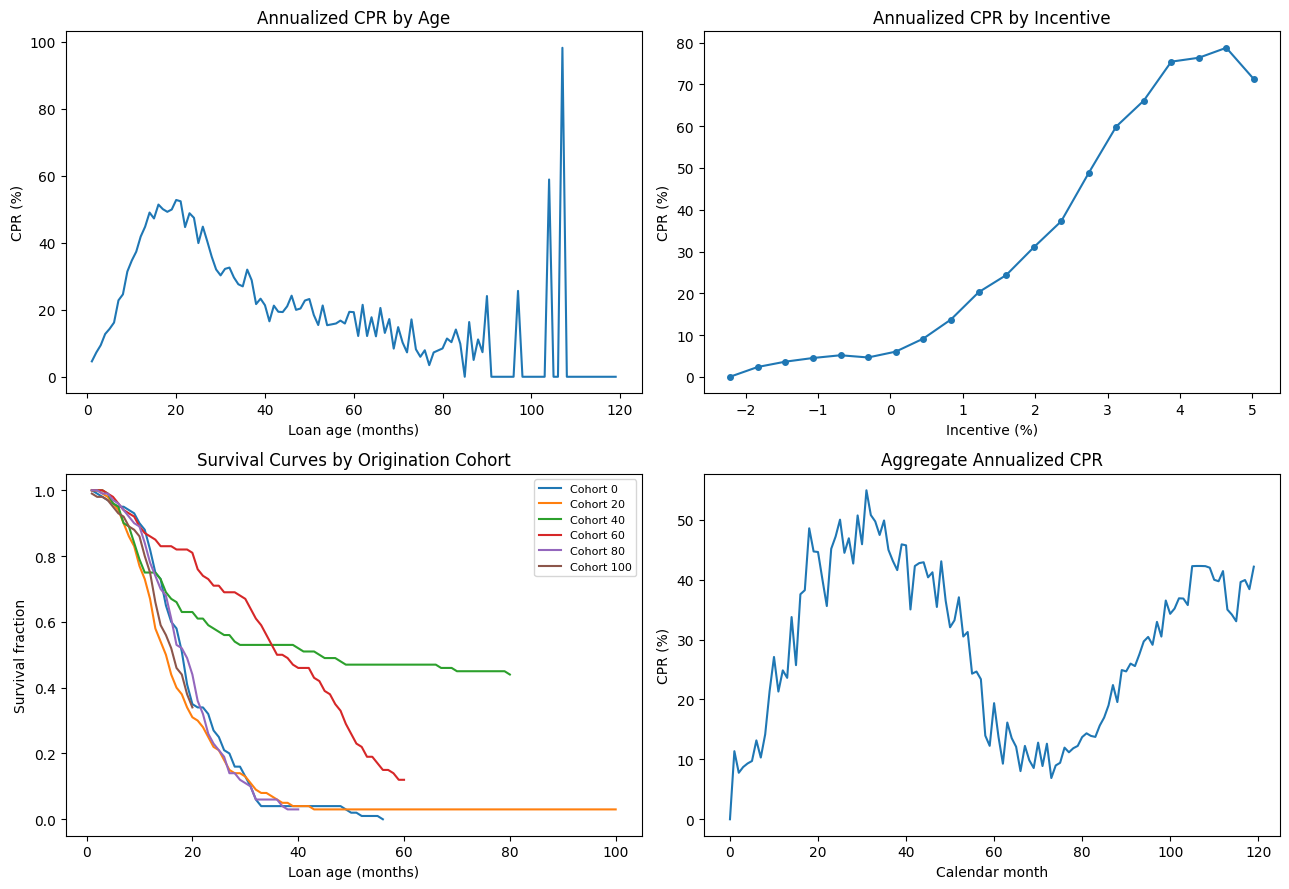

In [5]:
def smm_to_cpr(smm):
    """Annualize monthly prepay rate: CPR = 1 - (1-SMM)^12."""
    return 1 - (1 - smm) ** 12

fig, axes = plt.subplots(2, 2, figsize=(13, 9))

# (a) CPR vs loan age
by_age = df.groupby('loan_age')['prepaid'].mean()
axes[0, 0].plot(by_age.index, smm_to_cpr(by_age.values) * 100)
axes[0, 0].set(xlabel='Loan age (months)', ylabel='CPR (%)',
               title='Annualized CPR by Age')

# (b) CPR vs incentive (binned)
df['inc_bin'] = pd.cut(df['incentive'], bins=20)
by_inc = df.groupby('inc_bin', observed=True)['prepaid'].mean()
mid = np.array([iv.mid for iv in by_inc.index]) * 100
axes[0, 1].plot(mid, smm_to_cpr(by_inc.values) * 100, marker='o', ms=4)
axes[0, 1].set(xlabel='Incentive (%)', ylabel='CPR (%)',
               title='Annualized CPR by Incentive')

# (c) survival curves for selected cohorts
cohorts = [0, 20, 40, 60, 80, 100]
for c in cohorts:
    cohort = df[df['origination_month'] == c]
    n_orig = cohort[cohort['loan_age'] == 1].shape[0]
    cum_prepay = cohort.groupby('loan_age')['prepaid'].sum().cumsum()
    survival = 1.0 - cum_prepay / n_orig
    axes[1, 0].plot(survival.index, survival.values, label=f'Cohort {c}')
axes[1, 0].set(xlabel='Loan age (months)', ylabel='Survival fraction',
               title='Survival Curves by Origination Cohort')
axes[1, 0].legend(fontsize=8)

# (d) aggregate CPR over calendar time
by_cal = df.groupby('calendar_month')['prepaid'].agg(['sum', 'count'])
by_cal['smm'] = by_cal['sum'] / by_cal['count']
by_cal['cpr'] = smm_to_cpr(by_cal['smm'])
axes[1, 1].plot(by_cal.index, by_cal['cpr'] * 100)
axes[1, 1].set(xlabel='Calendar month', ylabel='CPR (%)',
               title='Aggregate Annualized CPR')

fig.tight_layout()
plt.show()

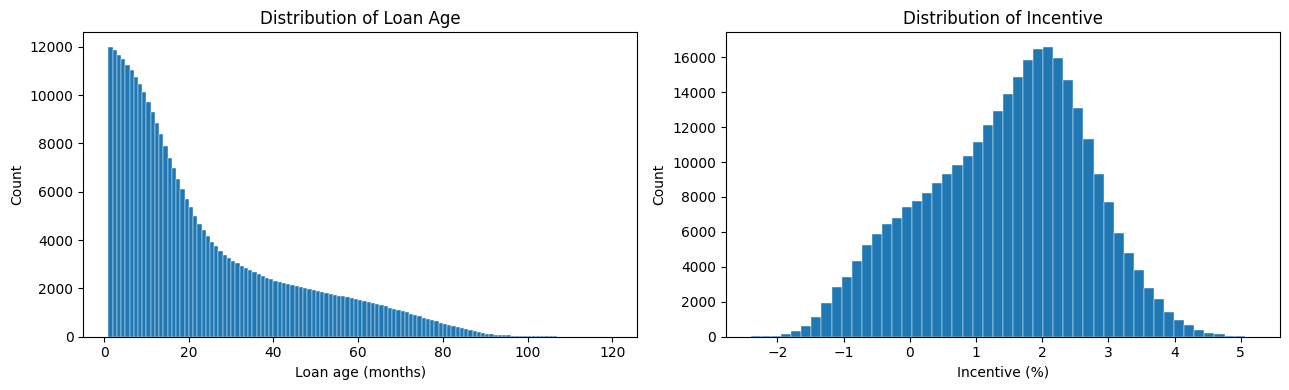

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

axes[0].hist(df['loan_age'], bins=range(1, df['loan_age'].max() + 2), edgecolor='white', linewidth=0.3)
axes[0].set(xlabel='Loan age (months)', ylabel='Count', title='Distribution of Loan Age')

axes[1].hist(df['incentive'] * 100, bins=50, edgecolor='white', linewidth=0.3)
axes[1].set(xlabel='Incentive (%)', ylabel='Count', title='Distribution of Incentive')

fig.tight_layout()
plt.show()

## GAM Fit

In [7]:
from pygam import LogisticGAM, s

df_model = df.copy()
df_model['loan_age'] = df_model['loan_age'].clip(upper=80)
df_model['incentive'] = df_model['incentive'].clip(-0.02, 0.04)

X = df_model[['loan_age', 'incentive']].values
y = df_model['prepaid'].values

gam = LogisticGAM(s(0, lam=10) + s(1, lam=10)).fit(X, y)
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     22.1615
Link Function:                        LogitLink Log Likelihood:                                -35690.9826
Number of Samples:                       310336 AIC:                                            71426.2883
                                                AICc:                                           71426.2919
                                                UBRE:                                               2.2302
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.119
Feature Function                  Lam

C:\Users\yimingz\AppData\Local\Temp\ipykernel_13808\3564874573.py:11: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


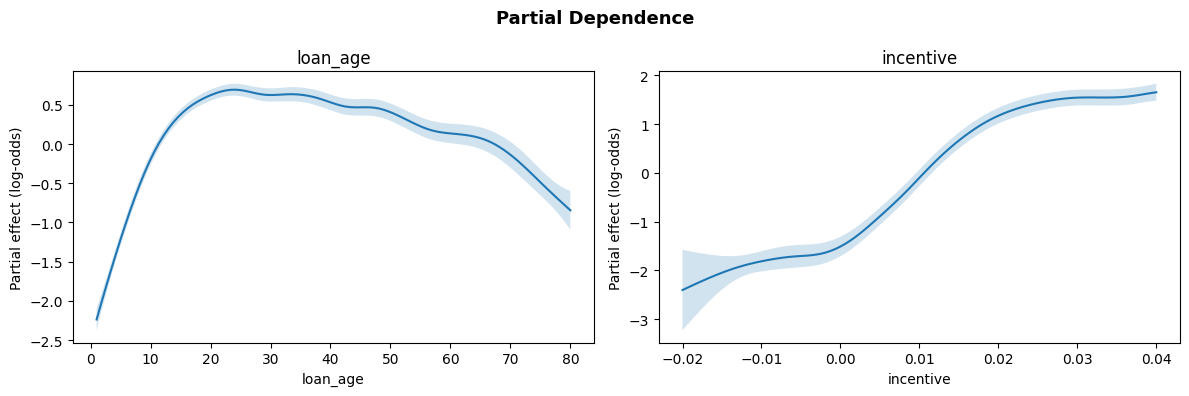

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, name in enumerate(['loan_age', 'incentive']):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    axes[i].plot(XX[:, i], pdep)
    axes[i].fill_between(XX[:, i], confi[:, 0], confi[:, 1], alpha=0.2)
    axes[i].set(xlabel=name, ylabel='Partial effect (log-odds)', title=f'{name}')

fig.suptitle('Partial Dependence', fontsize=13, fontweight='bold')
fig.tight_layout()
plt.show()

In [9]:
from quantbullet.plot.binned_plots import plot_binned_actual_vs_pred_plotnine

df_model['pred_gam'] = gam.predict_proba(X)
df_model['incentive_pct'] = df_model['incentive'] * 100
# round the incentive to its closest 0.1
df_model['incentive_pct_discrete'] = np.round(df_model['incentive_pct'], 1)

smm_to_cpr_pct = lambda x: (1 - (1 - x) ** 12) * 100

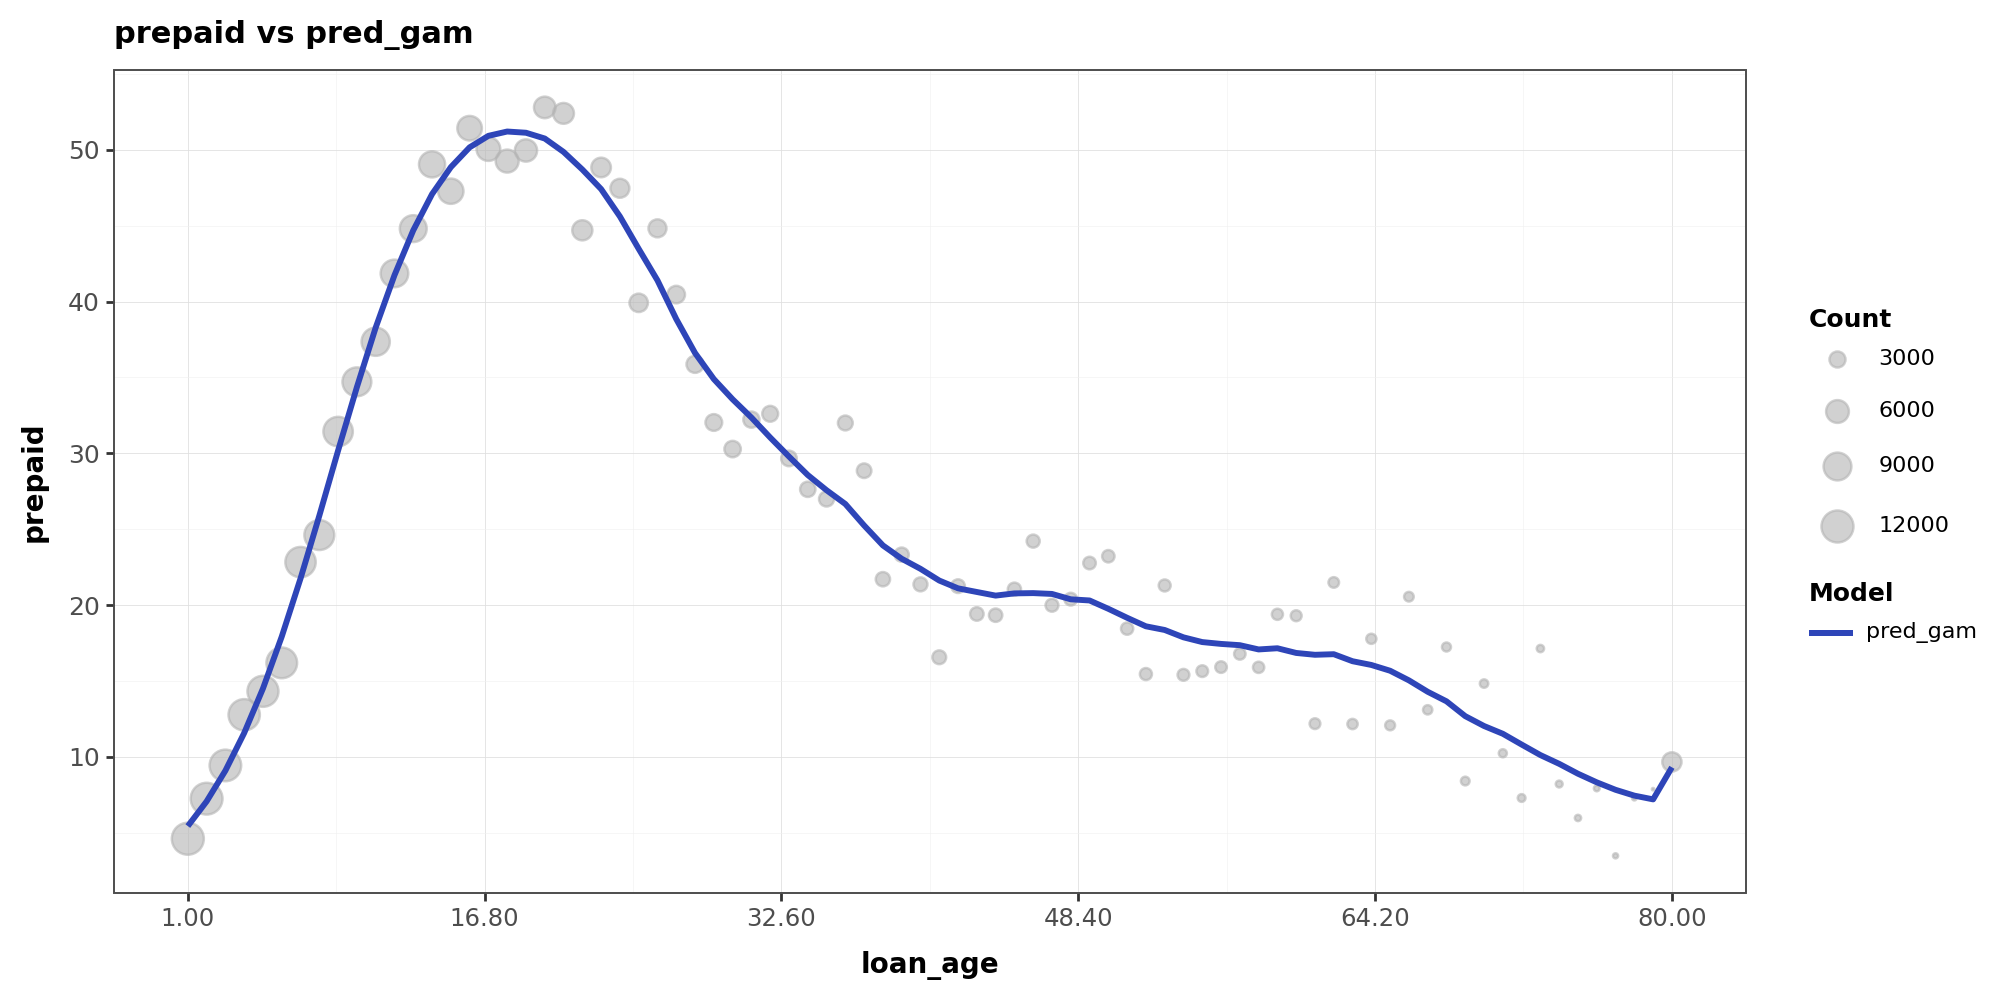

In [10]:
plot_binned_actual_vs_pred_plotnine(
    df_model, x_col='loan_age', act_col='prepaid', pred_col='pred_gam',
    bins=False, y_transform=smm_to_cpr_pct, figsize=(10, 5),
)

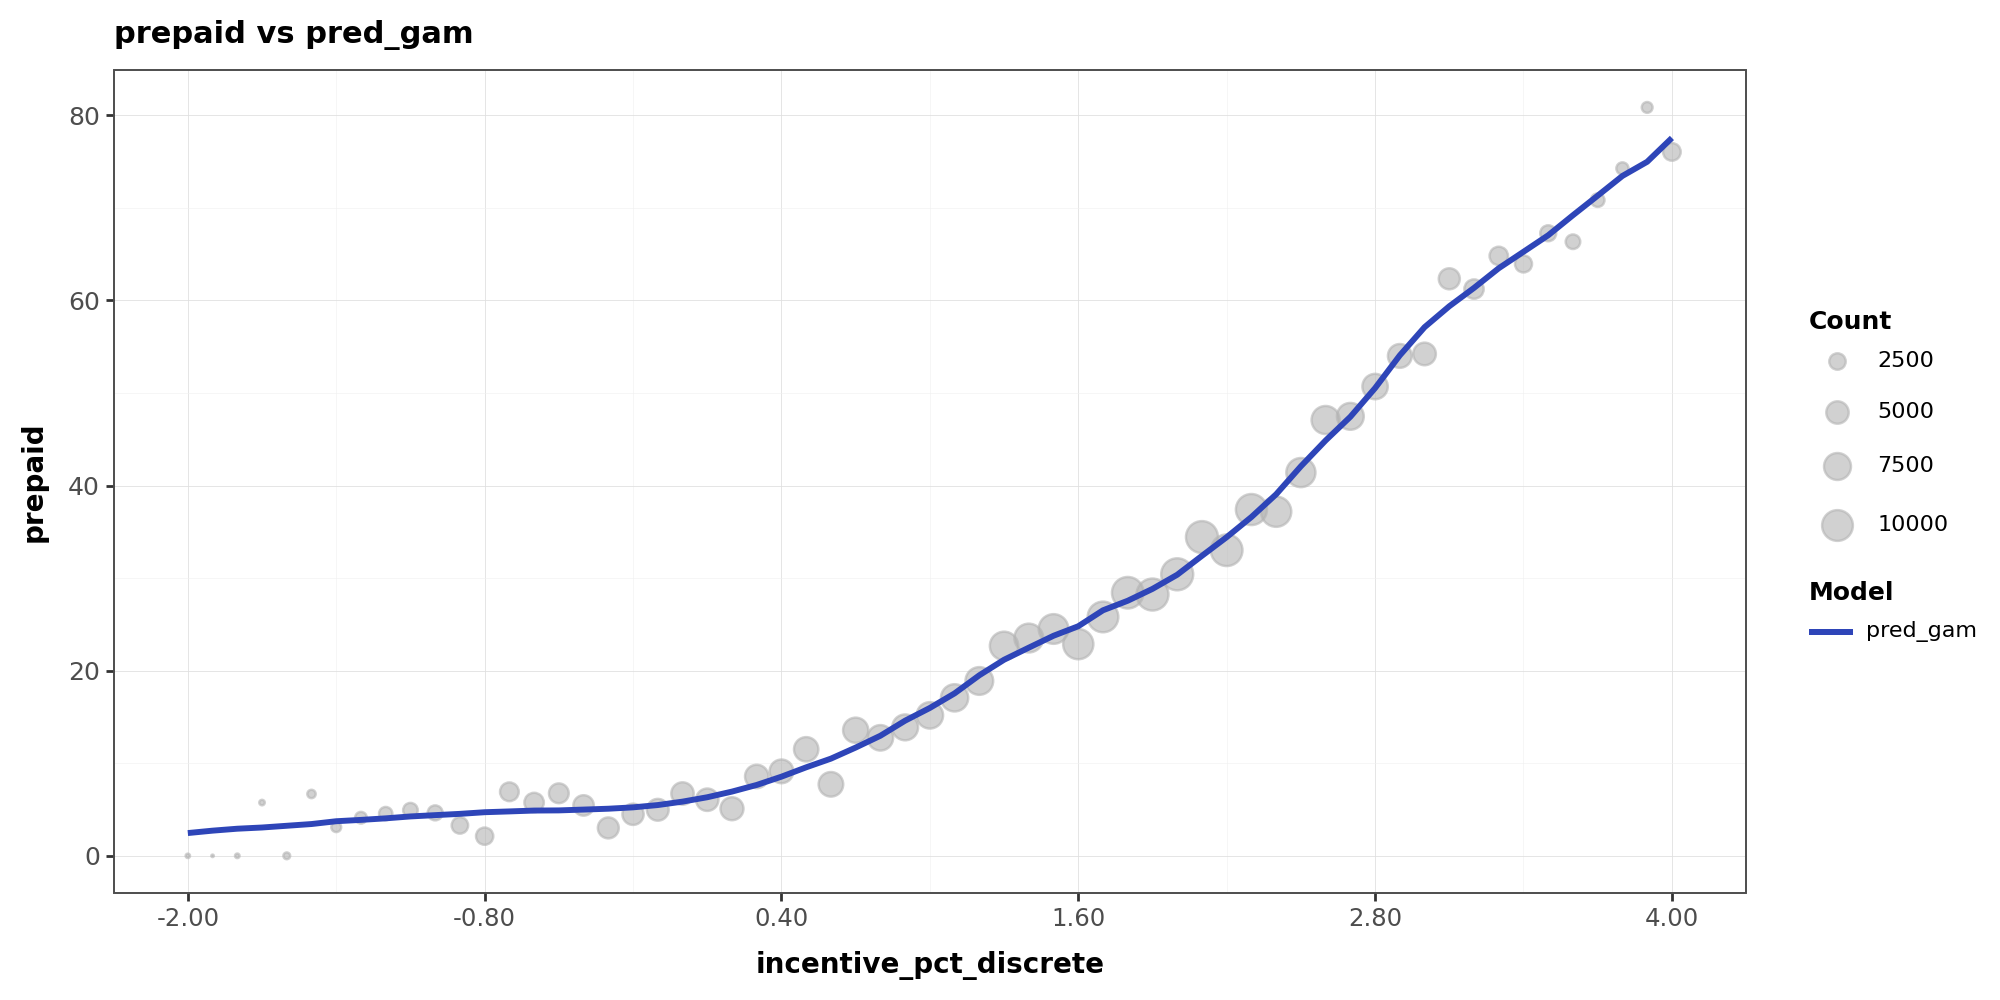

In [11]:
plot_binned_actual_vs_pred_plotnine(
    df_model, x_col='incentive_pct_discrete', act_col='prepaid', pred_col='pred_gam',
    bins=False, y_transform=smm_to_cpr_pct, figsize=(10, 5),
)

## Downsampling & Recalibration

Keep all prepaid events, downsample non-events to a target event rate, refit GAM, then correct predictions via:
1. **Prior correction** (Bayesian recalibration)
2. **King & Zeng intercept correction**

In [12]:
target_event_rate = 0.25

rng_ds = np.random.default_rng(42)
prepaid_mask = df_model['prepaid'] == 1
n_prepaid = prepaid_mask.sum()

n_unprepaid_target = int(n_prepaid * (1 - target_event_rate) / target_event_rate)
unprepaid_idx = df_model.index[~prepaid_mask].to_numpy()
sampled_idx = rng_ds.choice(unprepaid_idx, size=n_unprepaid_target, replace=False)

df_down = pd.concat([df_model[prepaid_mask], df_model.loc[sampled_idx]]).sort_index()

pi_true = df_model['prepaid'].mean()
pi_down = df_down['prepaid'].mean()

print(f"Full data:        {len(df_model):>10,} rows  |  event rate = {pi_true:.4f}")
print(f"Downsampled data: {len(df_down):>10,} rows  |  event rate = {pi_down:.4f}")

Full data:           310,336 rows  |  event rate = 0.0288
Downsampled data:     35,748 rows  |  event rate = 0.2500


In [13]:
X_down = df_down[['loan_age', 'incentive']].values
y_down = df_down['prepaid'].values

gam_down = LogisticGAM(s(0, lam=10) + s(1, lam=10)).fit(X_down, y_down)
gam_down.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     21.0089
Link Function:                        LogitLink Log Likelihood:                                -16440.2634
Number of Samples:                        35748 AIC:                                            32922.5446
                                                AICc:                                            32922.573
                                                UBRE:                                               2.9214
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1822
Feature Function                  Lam

C:\Users\yimingz\AppData\Local\Temp\ipykernel_13808\1402920593.py:5: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



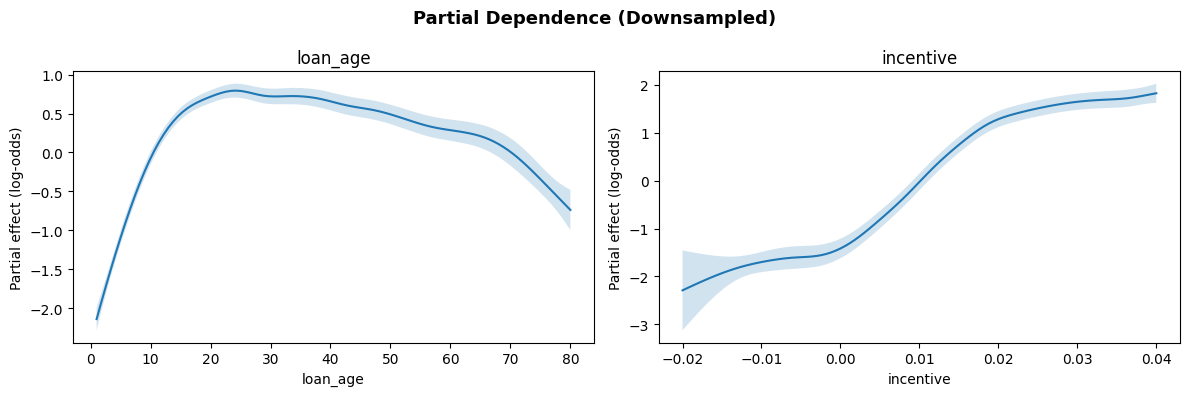

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, name in enumerate(['loan_age', 'incentive']):
    XX = gam_down.generate_X_grid(term=i)
    pdep, confi = gam_down.partial_dependence(term=i, X=XX, width=0.95)
    axes[i].plot(XX[:, i], pdep)
    axes[i].fill_between(XX[:, i], confi[:, 0], confi[:, 1], alpha=0.2)
    axes[i].set(xlabel=name, ylabel='Partial effect (log-odds)', title=f'{name}')

fig.suptitle('Partial Dependence (Downsampled)', fontsize=13, fontweight='bold')
fig.tight_layout()
plt.show()

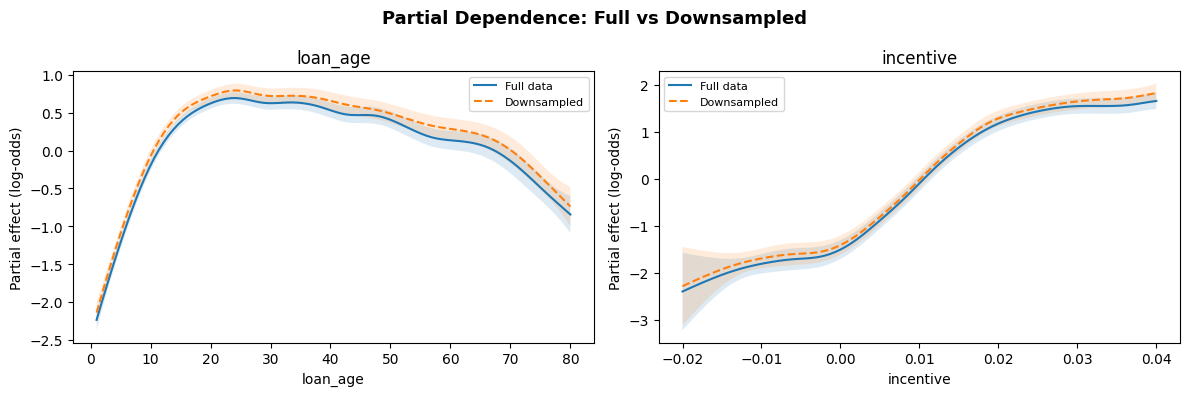

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, name in enumerate(['loan_age', 'incentive']):
    XX_f = gam.generate_X_grid(term=i)
    pdep_f, confi_f = gam.partial_dependence(term=i, X=XX_f, width=0.95)
    axes[i].plot(XX_f[:, i], pdep_f, label='Full data')
    axes[i].fill_between(XX_f[:, i], confi_f[:, 0], confi_f[:, 1], alpha=0.15)

    XX_d = gam_down.generate_X_grid(term=i)
    pdep_d, confi_d = gam_down.partial_dependence(term=i, X=XX_d, width=0.95)
    axes[i].plot(XX_d[:, i], pdep_d, ls='--', label='Downsampled')
    axes[i].fill_between(XX_d[:, i], confi_d[:, 0], confi_d[:, 1], alpha=0.15)

    axes[i].set(xlabel=name, ylabel='Partial effect (log-odds)', title=f'{name}')
    axes[i].legend(fontsize=8)

fig.suptitle('Partial Dependence: Full vs Downsampled', fontsize=13, fontweight='bold')
fig.tight_layout()
plt.show()

In [16]:
p_raw = np.clip(gam_down.predict_proba(X), 1e-10, 1 - 1e-10)

# Method 1: Bayesian prior correction (exact)
#   w = pi*(1-pi') / (pi'*(1-pi)),  p_corrected = w*p / (1 + (w-1)*p)
w = (pi_true * (1 - pi_down)) / (pi_down * (1 - pi_true))
df_model['pred_down_prior'] = (w * p_raw) / (1 + (w - 1) * p_raw)

# Method 2: King & Zeng intercept correction (shift logit by log-odds ratio)
#   logit_corrected = logit_raw + log(pi*(1-pi') / (pi'*(1-pi)))
kz_correction = np.log((pi_true * (1 - pi_down)) / (pi_down * (1 - pi_true)))
logit_raw = np.log(p_raw / (1 - p_raw))
df_model['pred_down_kz'] = _sigmoid(logit_raw + kz_correction)

# Uncorrected (for comparison)
df_model['pred_down_raw'] = p_raw

print(f"KZ intercept correction: {kz_correction:+.4f}")
print(f"Prior weight w:         {w:.4f}")
print()
print("Mean predicted probability (on full data):")
print(f"  Full-data GAM:          {df_model['pred_gam'].mean():.5f}")
print(f"  Downsampled raw:        {df_model['pred_down_raw'].mean():.5f}")
print(f"  Downsampled + prior:    {df_model['pred_down_prior'].mean():.5f}")
print(f"  Downsampled + KZ:       {df_model['pred_down_kz'].mean():.5f}")
print(f"  Actual:                 {df_model['prepaid'].mean():.5f}")

KZ intercept correction: -2.4196
Prior weight w:         0.0890

Mean predicted probability (on full data):
  Full-data GAM:          0.02880
  Downsampled raw:        0.20710
  Downsampled + prior:    0.02895
  Downsampled + KZ:       0.02895
  Actual:                 0.02880


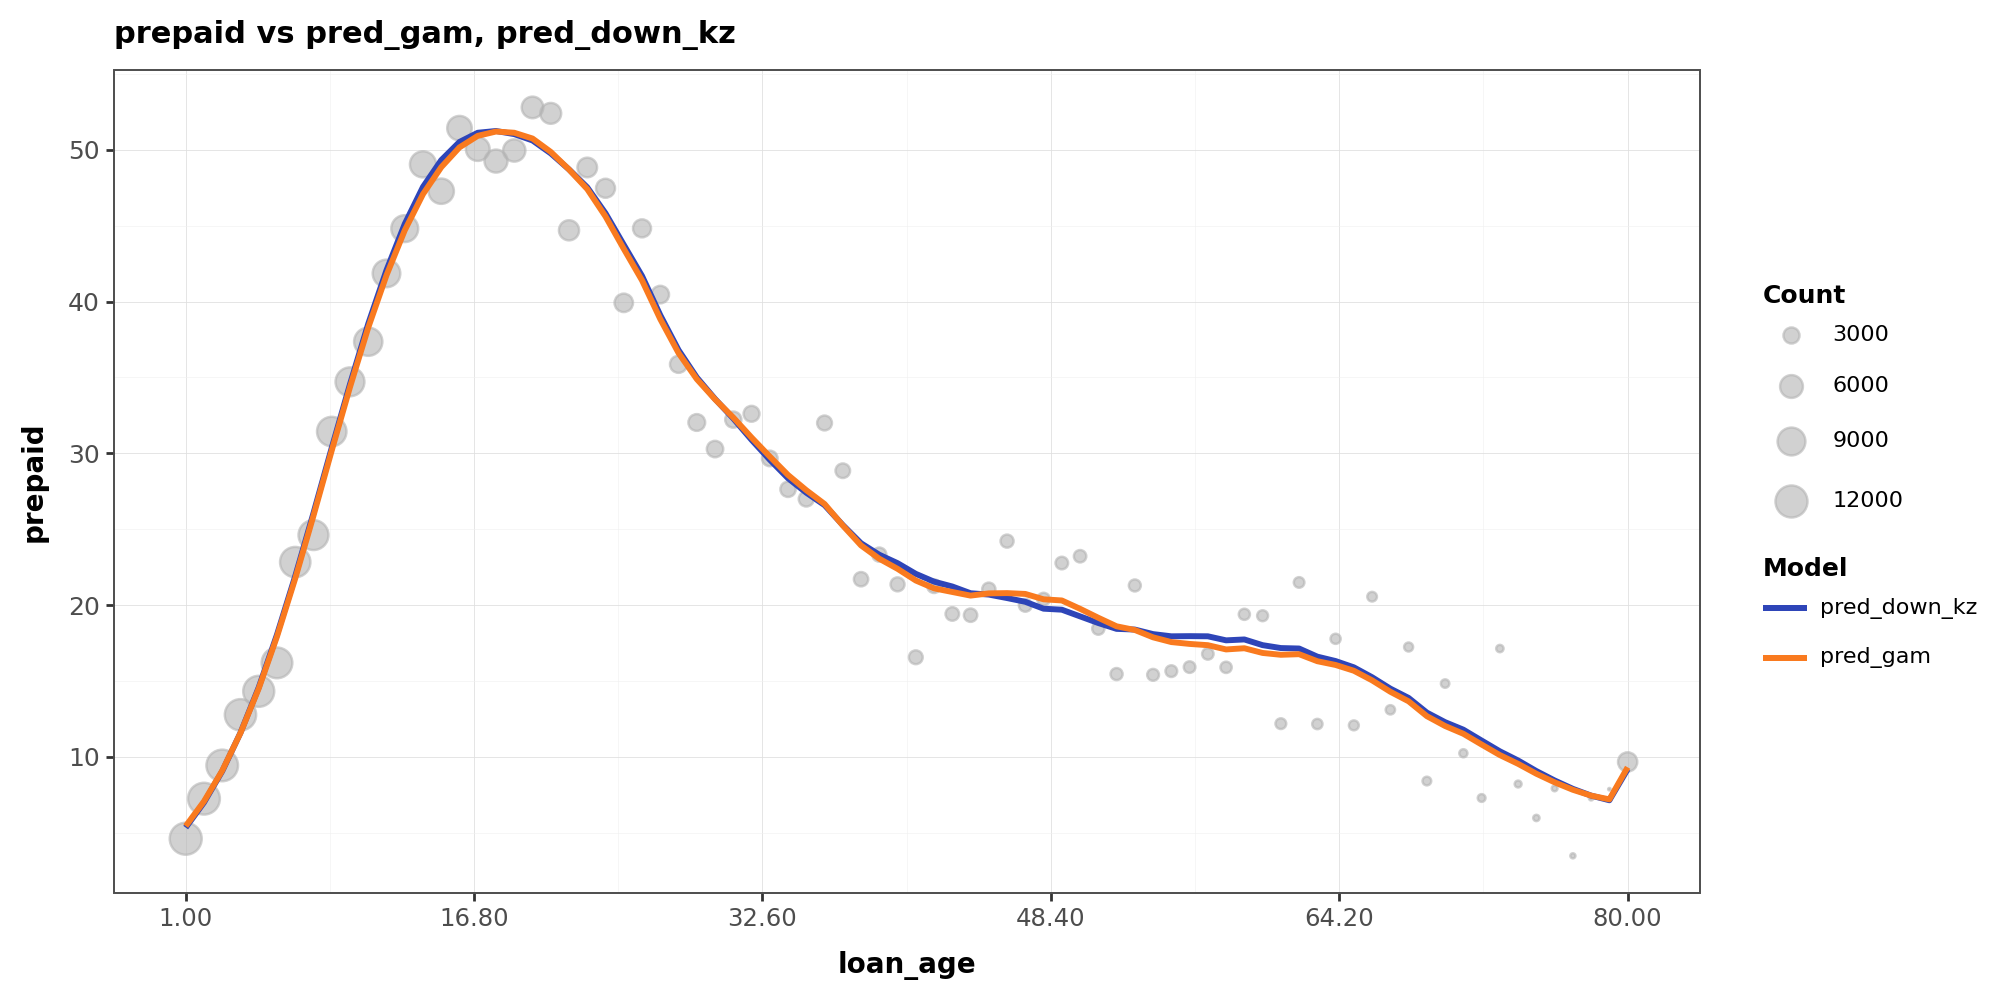

In [17]:
pred_cols = ['pred_gam', 'pred_down_prior', 'pred_down_kz', 'pred_down_raw']
pred_cols = ['pred_gam', 'pred_down_kz']

plot_binned_actual_vs_pred_plotnine(
    df_model, x_col='loan_age', act_col='prepaid', pred_col=pred_cols,
    bins=False, y_transform=smm_to_cpr_pct, figsize=(10, 5),
)

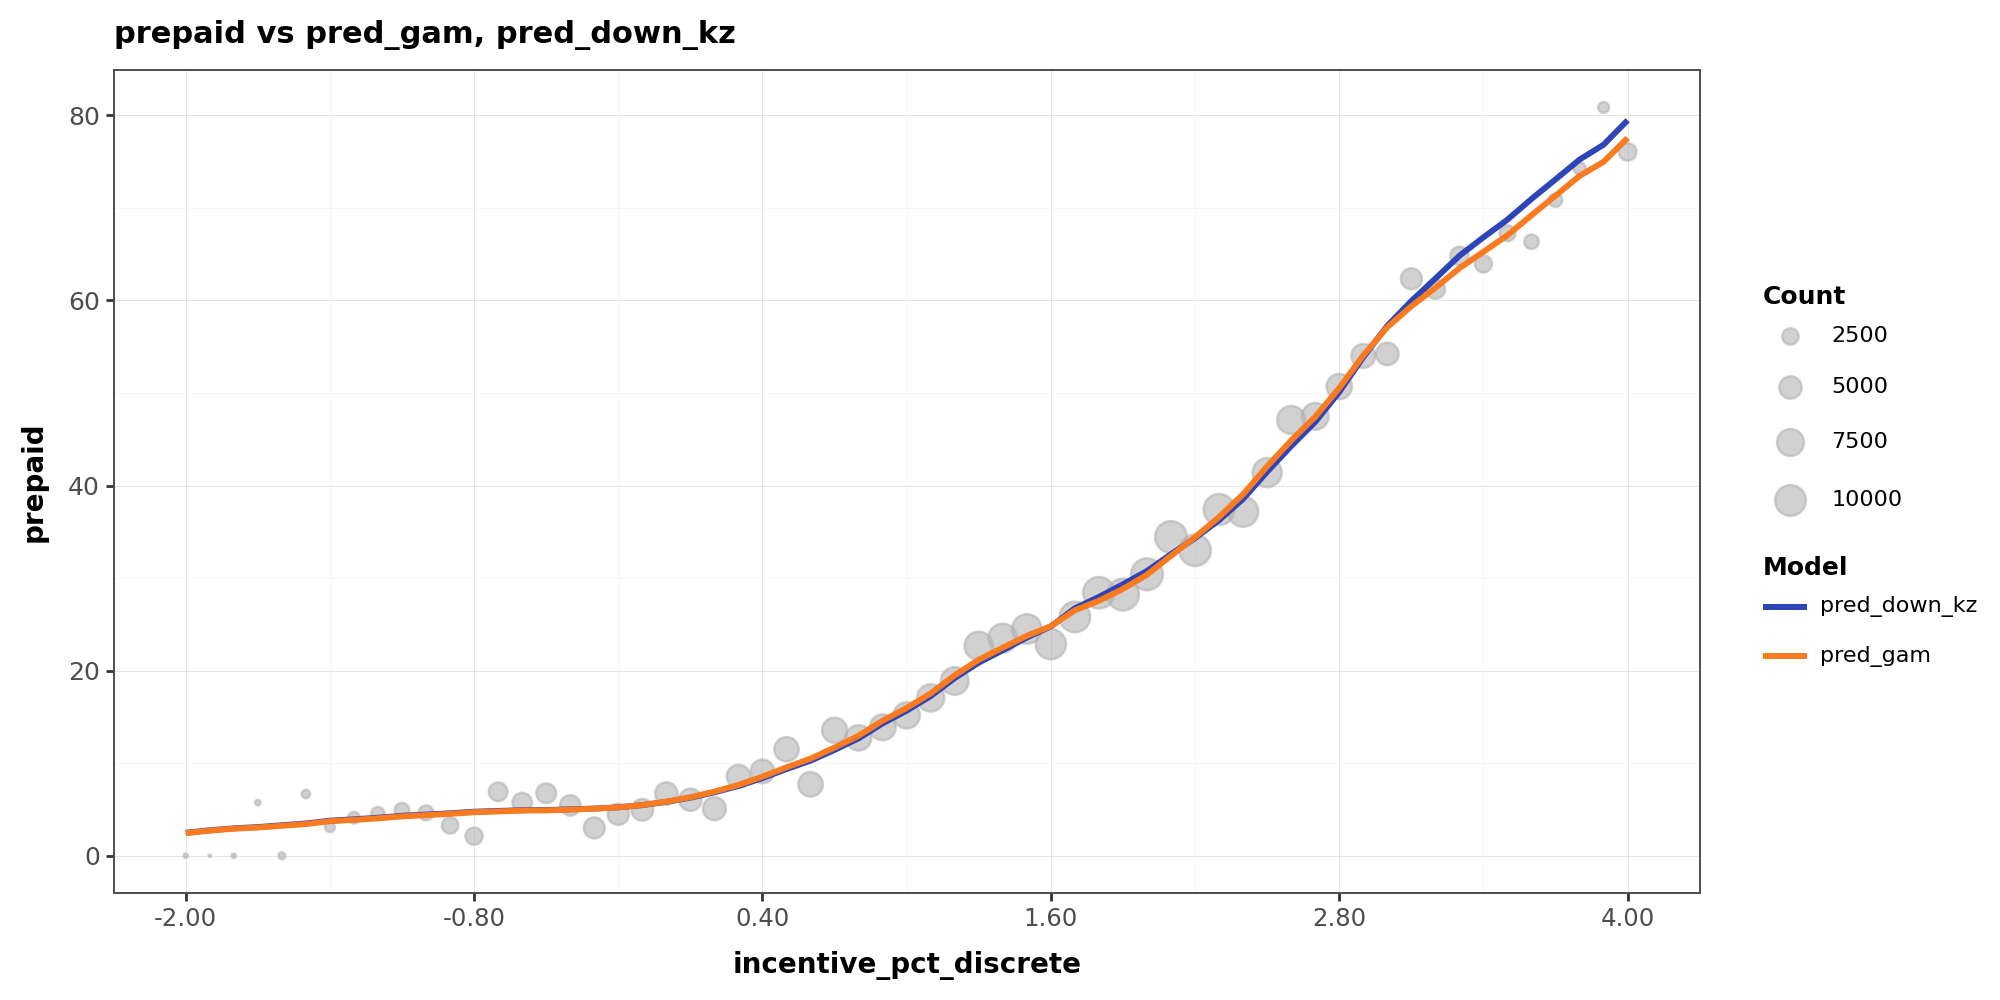

In [18]:
plot_binned_actual_vs_pred_plotnine(
    df_model, x_col='incentive_pct_discrete', act_col='prepaid', pred_col=pred_cols,
    bins=False, y_transform=smm_to_cpr_pct, figsize=(10, 5),
)